In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from keras import backend as K

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras import Model

import matplotlib.pyplot as plt

In [2]:
# Get S&P500 ticker symbols
_ = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
SAP_500_TICKERS = list(_[0]['Symbol'])
SAP_500_TICKERS[:10]

['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP']

In [2]:
DATA_SAVE_DIR = 'C:/_local/data_sets/'
DATA_SAVE_FILE_NAME = 's&p_500_5y_data.gz'
DATA_SAVE_PATH = DATA_SAVE_DIR + DATA_SAVE_FILE_NAME

## Get data from Yahoo Finance

In [67]:
# Gets data for a given ticker, and creates some features
# This is done for each ticker to avoid problems with moving averages over different tickers
def get_historical_data(ticker):
    
    tick = yf.Ticker(ticker)
    df = tick.history(period='5y')
    
    df = df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low',
                            'Close': 'close', 'Volume': 'volume', 
                            'Dividends': 'dividends', 
                            'Stock Splits': 'stock_splits'})
    
    if 'Adj Close' in df.columns:
        df.drop(['Adj Close'], axis=1, inplace=True)
        
    
    df['open_ma_3'] = df['open'].rolling(3).mean()
    df['open_ma_5'] = df['open'].rolling(5).mean()
    df['open_ma_10'] = df['open'].rolling(10).mean()
    
    df['volume_ma_3'] = df['volume'].rolling(3).mean()
    df['volume_ma_5'] = df['volume'].rolling(5).mean()
    df['volume_ma_10'] = df['volume'].rolling(10).mean()
    
    df['open_close'] = df['close'] - df['open']
    
    df['ticker'] = ticker
    
    return df
    

In [55]:
def get_data_for_all_tickers(tickers):
    
    dfs = [get_historical_data(t) for t in tickers]
    df = pd.concat(dfs, axis='index')
    return df.sort_values(by='Date', axis='index')

In [56]:
data = get_data_for_all_tickers(SAP_500_TICKERS)

- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [59]:
data.to_csv(DATA_SAVE_PATH, compression='gzip')

## Get data from storage

In [3]:
data_raw = pd.read_csv(DATA_SAVE_PATH, index_col=['Date'], parse_dates=['Date'])

In [5]:
data_raw.head()

,open,high,low,close,volume,dividends,stock_splits,open_ma_3,open_ma_5,open_ma_10,volume_ma_3,volume_ma_5,volume_ma_10,open_close,ticker,Adj Close
Date,,,,,,,,,,,,,,,,
2017-02-09,NaN,NaN,NaN,NaN,NaN,0.1000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAL,NaN
2017-02-09,NaN,NaN,NaN,NaN,NaN,1.2200,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GWW,NaN
2017-02-09,NaN,NaN,NaN,NaN,NaN,0.1425,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,NaN
2017-02-09,NaN,NaN,NaN,NaN,NaN,0.4000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COF,NaN
2017-02-09,NaN,NaN,NaN,NaN,NaN,0.7500,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AMP,NaN


In [6]:
data_raw.shape

(626436, 16)

## Data cleaning

In [7]:
# Adj close is nan for almost all entries
data_raw.drop(['Adj Close'], axis=1, inplace=True)

In [8]:
# Extract days from dates
data_raw['day_of_week'] = data_raw.index.dayofweek
data_raw['day_of_month'] = data_raw.index.day
#data['month'] = data.index.month <-- this gave worse results than when excluding it

# Remove missing / bad values
data_raw.replace([-np.Inf, np.Inf], np.nan, inplace=True)
data_raw.dropna(how='any', inplace=True)

In [9]:
# Get first date for each ticker
ticker_date_groups = data_raw[['ticker']].reset_index().groupby(['ticker']).min()
ticker_date_groups.value_counts()

Date      
2017-02-24    492
2020-04-01      2
2017-05-25      1
2018-05-09      1
2018-12-20      1
2019-03-25      1
2019-03-26      1
2019-04-02      1
2019-06-07      1
2021-05-27      1
2022-02-01      1
dtype: int64

In [10]:
# Remove tickers which do not have data on 2017-02-24
earliest_date = ticker_date_groups['Date'].min()
recently_added_tickers = list(ticker_date_groups[ticker_date_groups['Date']>earliest_date].index)

data_raw = data_raw[data_raw['ticker'].isin(recently_added_tickers)==False]

In [11]:
# Subset data to only include top 50 tickers wrt total volume

ticker_volume_means = data_raw[['ticker', 'volume']].groupby(['ticker']).mean().sort_values('volume', ascending=False)
high_volume_tickers = list(ticker_volume_means.index[:50])

data_raw = data_raw[data_raw['ticker'].isin(high_volume_tickers)==True]

In [12]:
# Apply min-max scaling to each numeric variable

data = data_raw.copy()

non_ticker_cols = [c for c in data.columns if c != 'ticker']
data[non_ticker_cols] = data[non_ticker_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [13]:
# Integer encoding of ticker symbols
ticker_label_encoder = LabelEncoder().fit(data['ticker'])
encoded_tickers = ticker_label_encoder.transform(data['ticker'])

# One-hot encoding of ticker symbols
one_hot_tickers = tf.keras.utils.to_categorical(encoded_tickers)
one_hot_tickers_df = pd.DataFrame(one_hot_tickers, index=data.index)

In [14]:
# Split data into training and testing
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    data, one_hot_tickers_df, test_size=.2, random_state=11
)

# Split training data into training and validation
X_train_df, X_valid_df, y_train_df, y_valid_df = train_test_split(
    X_train_df, y_train_df, test_size=.15, random_state=13
)

In [15]:
# Hyper-parameters
LATENT_DIM = 16
BATCH_SIZE = 64

In [16]:
# Truncate data to be multiple of batch size
train_truncate_val = X_train_df.shape[0] - X_train_df.shape[0] % BATCH_SIZE
valid_truncate_val = X_valid_df.shape[0] - X_valid_df.shape[0] % BATCH_SIZE
test_truncate_val = X_test_df.shape[0] - X_test_df.shape[0] % BATCH_SIZE

X_train_df = X_train_df.iloc[:train_truncate_val, :]
y_train_df = y_train_df.iloc[:train_truncate_val, :]

X_valid_df = X_valid_df.iloc[:valid_truncate_val, :]
y_valid_df = y_valid_df.iloc[:valid_truncate_val, :]

X_test_df = X_test_df.iloc[:test_truncate_val, :]
y_test_df = y_test_df.iloc[:test_truncate_val, :]

In [17]:
# Get numpy versions of dataframes for training
X_train = X_train_df.drop(['ticker'], axis=1).to_numpy()
y_train = y_train_df.to_numpy()

X_valid = X_valid_df.drop(['ticker'], axis=1).to_numpy()
y_valid = y_valid_df.to_numpy()

X_test = X_test_df.drop(['ticker'], axis=1).to_numpy()
y_test = y_test_df.to_numpy()

## Creating Conditional Variational Autoencoder

In [114]:
# CVAE input layers
X = Input(shape=(X_train.shape[1],), name='x_input')
Y = Input(shape=(y_train.shape[1],), name='y_input')

X_Y_concat = tf.keras.layers.concatenate([X, Y], name='x_y_concat')

In [115]:
# Encoder specification
encoder_dense_1 = Dense(128, activation='relu', name='encoder_dense_1')(X_Y_concat)
encoder_dropout_1 = Dropout(.5, name='encoder_dropout_1')(encoder_dense_1)
encoder_dense_2 = Dense(128, activation='relu', name='encoder_dense_2')(encoder_dropout_1)
encoder_dropout_2 = Dropout(.5, name='encoder_dropout_2')(encoder_dense_2)
encoder_dense_3 = Dense(128, activation='relu', name='encoder_dense_3')(encoder_dropout_2)
encoder_dropout_3 = Dropout(.5, name='encoder_dropout_3')(encoder_dense_3)

encoder_mu = Dense(LATENT_DIM, activation='linear', name='encoder_mu')(encoder_dropout_3)
encoder_log_sigma = Dense(LATENT_DIM, activation='linear', name='encoder_log_sigma')(encoder_dropout_3)

encoder = Model([X, Y], encoder_mu, name='encoder')

In [116]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_input (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 y_input (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 x_y_concat (Concatenate)       (None, 66)           0           ['x_input[0][0]',                
                                                                  'y_input[0][0]']                
                                                                                                  
 encoder_dense_1 (Dense)        (None, 128)          8576        ['x_y_concat[0][0]']       

In [117]:
# Reparameterization and concatenation layers / specification
def sample_and_reparameterize(mu_logsigma):
    mu, log_sigma = mu_logsigma
    eps = K.random_normal(shape=(LATENT_DIM,))
    return mu + K.exp(log_sigma * .5) * eps

Z = tf.keras.layers.Lambda(sample_and_reparameterize, output_shape=(LATENT_DIM,), 
                        name='sample_and_reparameterize')([encoder_mu, encoder_log_sigma])

Z_Y_concat = tf.keras.layers.concatenate([Z, Y], name='z_y_concat')

In [118]:
# Loss functions
def reconstruction_loss(x_true, x_pred):
    cross_entropy = K.binary_crossentropy(x_true, x_pred)
    return K.sum(cross_entropy, axis=-1)

def kl_divergence(x_true, x_pred, emu, els):
    _ = K.exp(els) + K.square(emu) - 1. - els
    return .5 * K.sum(_, axis=1)

def vae_loss(x_true, x_pred, emu, els):
    return reconstruction_loss(x_true, x_pred) + kl_divergence(x_true, x_pred, emu, els)

In [119]:
# Decoder layers
decoder_dense_layer_1 = Dense(128, activation='relu', name='decoder_dense_1')
decoder_dropout_layer_1 = Dropout(.5, name='decoder_dropout_1')
decoder_dense_layer_2 = Dense(128, activation='relu', name='decoder_dense_2')
decoder_dropout_layer_2 = Dropout(.5, name='decoder_dropout_2')
decoder_dense_layer_3 = Dense(128, activation='relu', name='decoder_dense_3')
decoder_dropout_layer_3 = Dropout(.5, name='decoder_dropout_3')
decoder_output_layer = Dense(X_train.shape[1], activation='sigmoid', name='decoder_output')

# Decoder specification
d1 = decoder_dense_layer_1(Z_Y_concat)
d2 = decoder_dropout_layer_1(d1)
d3 = decoder_dense_layer_2(d2)
d4 = decoder_dropout_layer_2(d3)
d5 = decoder_dense_layer_3(d4)
d6 = decoder_dropout_layer_3(d5)
cvae_output = decoder_output_layer(d6)

decoder_input = Input(shape=(LATENT_DIM+y_train.shape[1],), name='decoder_input')
decoder_dense_1 = decoder_dense_layer_1(decoder_input)
decoder_dropout_1 = decoder_dropout_layer_1(decoder_dense_1)
decoder_dense_2 = decoder_dense_layer_2(decoder_dropout_1)
decoder_dropout_2 = decoder_dropout_layer_2(decoder_dense_2)
decoder_dense_3 = decoder_dense_layer_3(decoder_dropout_2)
decoder_dropout_3 = decoder_dropout_layer_3(decoder_dense_3)
decoder_output = decoder_output_layer(decoder_dropout_3)

decoder = Model(decoder_input, decoder_output, name='decoder')

cvae = Model([X, Y], cvae_output, name='cvae')

In [120]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 66)]              0         
                                                                 
 decoder_dense_1 (Dense)     (None, 128)               8576      
                                                                 
 decoder_dropout_1 (Dropout)  (None, 128)              0         
                                                                 
 decoder_dense_2 (Dense)     (None, 128)               16512     
                                                                 
 decoder_dropout_2 (Dropout)  (None, 128)              0         
                                                                 
 decoder_dense_3 (Dense)     (None, 128)               16512     
                                                                 
 decoder_dropout_3 (Dropout)  (None, 128)              0   

In [121]:
cvae.summary()

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_input (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 y_input (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 x_y_concat (Concatenate)       (None, 66)           0           ['x_input[0][0]',                
                                                                  'y_input[0][0]']                
                                                                                                  
 encoder_dense_1 (Dense)        (None, 128)          8576        ['x_y_concat[0][0]']          

## Model training

In [122]:
if len(cvae.losses) == 0:
    cvae.add_loss(vae_loss(X, cvae_output, encoder_mu, encoder_log_sigma))
    
if len(cvae.metrics) == 0:
    cvae.add_metric(reconstruction_loss(X, cvae_output), name='reconstruction_loss')
    cvae.add_metric(kl_divergence(X, cvae_output, encoder_mu, encoder_log_sigma), name='kl_divergence')
    
cvae.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=None)

early_stop_clbk = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.001, patience=5)
reduce_lr_clbk = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=.001, patience=3)

callbacks = [early_stop_clbk, reduce_lr_clbk]

cvae_training_history = cvae.fit(
    [X_train, y_train], X_train,
    batch_size=BATCH_SIZE, epochs=100,
    validation_data=([X_valid, y_valid], X_valid),
    callbacks=callbacks
).history

Epoch 1/100
664/664 [==============================] - 2s 2ms/step - loss: 4.6533 - reconstruction_loss: 4.6471 - kl_divergence: 0.0062 - val_loss: 4.2144 - val_reconstruction_loss: 4.2137 - val_kl_divergence: 6.1267e-04 - lr: 0.0010
Epoch 2/100
664/664 [==============================] - 1s 2ms/step - loss: 4.2251 - reconstruction_loss: 4.2240 - kl_divergence: 0.0011 - val_loss: 4.1531 - val_reconstruction_loss: 4.1529 - val_kl_divergence: 1.9916e-04 - lr: 0.0010
Epoch 3/100
664/664 [==============================] - 1s 2ms/step - loss: 4.1559 - reconstruction_loss: 4.1555 - kl_divergence: 3.5311e-04 - val_loss: 4.0732 - val_reconstruction_loss: 4.0732 - val_kl_divergence: 2.5856e-05 - lr: 0.0010
Epoch 4/100
664/664 [==============================] - 1s 2ms/step - loss: 4.1075 - reconstruction_loss: 4.1074 - kl_divergence: 9.4424e-05 - val_loss: 4.0574 - val_reconstruction_loss: 4.0574 - val_kl_divergence: 6.4854e-06 - lr: 0.0010
Epoch 5/100
664/664 [==============================] - 1

## Evaluate model on test data

In [123]:
# Calculate loss and metrics over test set
cvae.evaluate(x=[X_test, y_test], y=X_test,
              batch_size=BATCH_SIZE
             );

195/195 [==============================] - 0s 828us/step - loss: 4.0447 - reconstruction_loss: 4.0447 - kl_divergence: 1.4605e-08


## Find anomalous data points

In [124]:
# It would take about 20 mins to get the individual loss and metrics for each observation in the test set
# since we would have to evaluate with batches of size 1, so we will only look at a subset of the test data

np.random.seed(19)
test_evaluation_indices = np.random.choice(np.arange(X_test.shape[0]), replace=False, size=1500)

In [125]:
# Get reconstruction error for each observation in subset of test set

test_index_recon_loss_dict = {}
for index in test_evaluation_indices:
        
    X = X_test[index:index+1, :]
    y = y_test[index:index+1, :]
    
    loss_dict = cvae.evaluate(x=[X, y], y=y, 
                              batch_size=1, return_dict=True, verbose=0)
    
    test_index_recon_loss_dict[index] = loss_dict['reconstruction_loss']

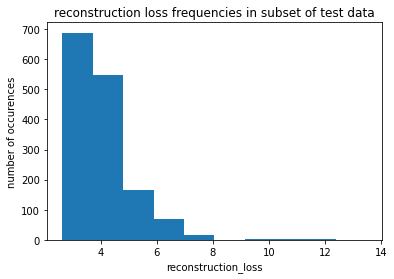

In [126]:
plt.hist(test_index_recon_loss_dict.values())
plt.xlabel('reconstruction_loss')
plt.ylabel('number of occurences')
plt.title('reconstruction loss frequencies in subset of test data');

In [127]:
print('reconstruction_loss percentiles in subset of test set')
print(f'90th percentile: {np.percentile(list(test_index_recon_loss_dict.values()), 90)}')
print(f'95th percentile: {np.percentile(list(test_index_recon_loss_dict.values()), 95)}')
print(f'97.5th percentile: {np.percentile(list(test_index_recon_loss_dict.values()), 97.5)}')
print(f'99th percentile: {np.percentile(list(test_index_recon_loss_dict.values()), 99)}')

reconstruction_loss percentiles in subset of test set
90th percentile: 5.462898683547976
95th percentile: 6.137582564353942
97.5th percentile: 6.752549695968627
99th percentile: 7.637394232749939


In [158]:
# We'll consider any reconstruction loss above ANOMALY_THRESHOLD_VALUE as anomalous
ANOMALY_THRESHOLD_VALUE = np.percentile(list(test_index_recon_loss_dict.values()), 98)

In [159]:
anomalous_test_set_indices = [index for 
                              index, recon_loss in test_index_recon_loss_dict.items()
                              if recon_loss >= ANOMALY_THRESHOLD_VALUE]

In [160]:
anomalies_per_ticker_df = X_test_df['ticker'].iloc[anomalous_test_set_indices].value_counts()
most_anomalous_stocks = list(anomalies_per_ticker_df.index)
anomalies_per_ticker_df

TSLA    11
FB       7
MSFT     4
NVDA     3
AAPL     3
CCL      1
BA       1
Name: ticker, dtype: int64

In [166]:
# Let's take a look at a particular stock
anomalous_stock = 'TSLA'

X_test_df_anomalous = X_test_df.iloc[anomalous_test_set_indices, :] 
anomalous_stock_anomaly_dates = list(X_test_df_anomalous[X_test_df_anomalous['ticker']==anomalous_stock].index)

print(f'anomalous stock: {anomalous_stock} --- number of anomalies: {len(anomalous_stock_anomaly_dates)}')

anomalous stock: TSLA --- number of anomalies: 11


In [167]:
first_anomaly = min(anomalous_stock_anomaly_dates)
first_plot_date = first_anomaly - pd.to_timedelta(20, unit='d')

X_anomalous_stock_df = data_raw[data_raw['ticker']==anomalous_stock]
X_anomalous_stock_df = X_anomalous_stock_df[X_anomalous_stock_df.index>=first_plot_date]
X_anomalous_stock_df = X_anomalous_stock_df.sort_values(axis=0, by='Date')

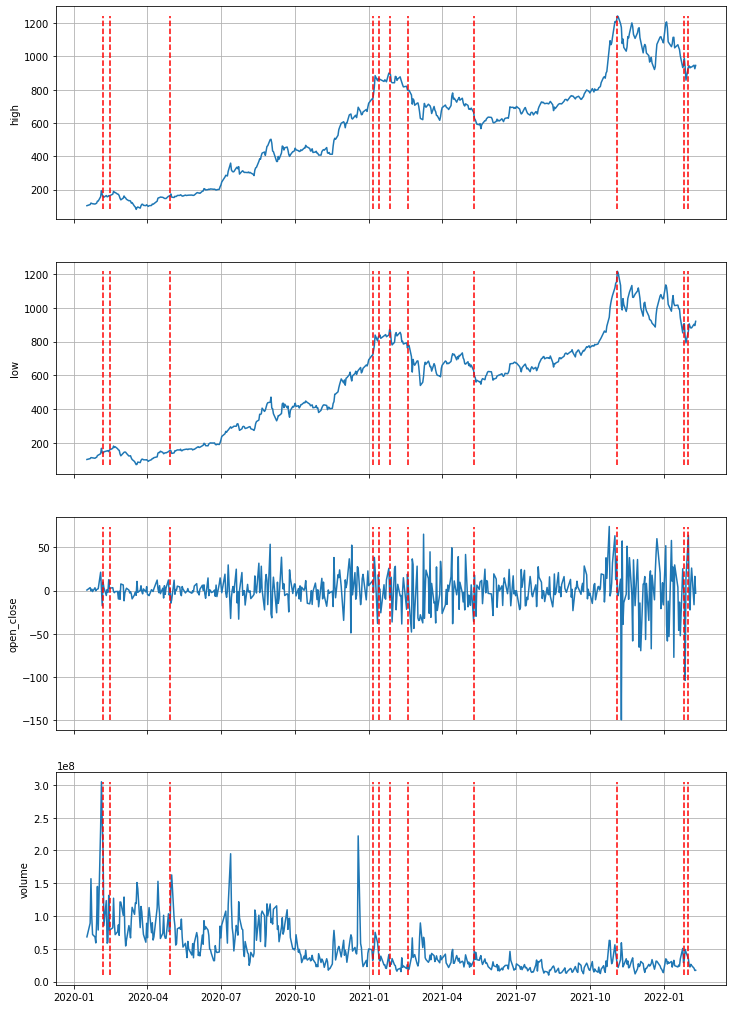

In [168]:
plot_vars = ['high', 'low', 'open_close', 'volume']

fig, axs = plt.subplots(len(plot_vars), 1, sharex=True, figsize=(12, 18))
for a, (ax, var) in enumerate(zip(axs, plot_vars)):
    
    ax.plot(X_anomalous_stock_df[var])
    
    ymin = X_anomalous_stock_df[var].min()
    ymax = X_anomalous_stock_df[var].max()
        
    for date in anomalous_stock_anomaly_dates:
        ax.vlines(x=date, 
                   ymin=ymin, ymax=ymax,
                   color='red', linestyle='dashed'
                  )
        
    
    ax.grid(True)
    ax.set_ylabel(var)
    

In [169]:
sorted(anomalous_stock_anomaly_dates)

[Timestamp('2020-02-06 00:00:00'),
 Timestamp('2020-02-14 00:00:00'),
 Timestamp('2020-04-29 00:00:00'),
 Timestamp('2021-01-05 00:00:00'),
 Timestamp('2021-01-13 00:00:00'),
 Timestamp('2021-01-27 00:00:00'),
 Timestamp('2021-02-18 00:00:00'),
 Timestamp('2021-05-10 00:00:00'),
 Timestamp('2021-11-03 00:00:00'),
 Timestamp('2022-01-26 00:00:00'),
 Timestamp('2022-01-31 00:00:00')]

Looking up those dates on the Internet, we find...

**Tesla temporarily closes China stores amid coronavirus fears**
https://www.cnbc.com/2020/02/06/tesla-temporarily-closes-china-stores-amid-virus-fears.html (2020-02-06)

**U.S. vehicle safety agency asks Tesla to recall 158,716 older vehicles over touchscreen glitches**
https://www.cnbc.com/2021/01/13/nhtsa-asks-tesla-to-recall-158716-model-x-s-over-touchscreen-glitch.html (2021-01-13)

**JD Power says Lexus is most dependable auto brand, ranks Tesla 30th out of 33**
https://www.cnbc.com/2021/02/18/tesla-ranks-30th-in-unofficial-debut-on-jd-power-dependability-study.html (2021-02-18)

**NTSB releases preliminary report on fatal Tesla crash in Spring, Texas**
https://www.cnbc.com/2021/05/10/ntsb-releases-preliminary-report-on-fatal-tesla-crash-in-spring-texas.html

**Tesla beats on earnings and revenue, says supply chain issues were ‘main limiting factor’**
https://www.cnbc.com/2022/01/26/tesla-tsla-earnings-q4-2021.html (2021-01-26)